#**Deep Learning Homework 4: Recurrent Neural Networks & Transformer**

### MSc Computer Science, Data Science, Cybersecurity @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime tipe* at the bottom of the page, and then select the GPU hardware accelerator.  

##Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [2]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17473536/17464789 [==============================] - 0s 0us/step


Let's also get the word indexs (word to word-id)

In [3]:
word_index = keras.datasets.imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur. Notice that Keras does not use index 0, so we can shift the indices only by 3 positions.

In [4]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [5]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [6]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [7]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

### Model Definition
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer 

**[TO COMPLETE]** In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in `model.compile()` and motivate your choice.


Please, insert your answer in this text cell.

**Answer:**

The right activation function to insert in the output layer is *sigmoid* since we are performing a binary classification. The function returns a value between 0 and 1 and it indicates wheter a sample belongs more to a specific class or to the other one.

The loss function used is *binary cross-entropy*, because the current task is a binary classification, where the two output labels are 0 and 1.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(units=32, activation='tanh'))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1376      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


Now we have to train the model:

In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 125s 616ms/step - loss: 0.6530 - accuracy: 0.6085 - val_loss: 0.4773 - val_accuracy: 0.7943
Epoch 2/10
196/196 [==============================] - 121s 616ms/step - loss: 0.3742 - accuracy: 0.8430 - val_loss: 0.3695 - val_accuracy: 0.8413
Epoch 3/10
196/196 [==============================] - 119s 607ms/step - loss: 0.2840 - accuracy: 0.8888 - val_loss: 0.3568 - val_accuracy: 0.8509
Epoch 4/10
196/196 [==============================] - 120s 611ms/step - loss: 0.2249 - accuracy: 0.9158 - val_loss: 0.3331 - val_accuracy: 0.8604
Epoch 5/10
196/196 [==============================] - 121s 615ms/step - loss: 0.1841 - accuracy: 0.9339 - val_loss: 0.3623 - val_accuracy: 0.8430
Epoch 6/10
196/196 [==============================] - 121s 617ms/step - loss: 0.1492 - accuracy: 0.9490 - val_loss: 0.3894 - val_accuracy: 0.8586
Epoch 7/10
196/196 [==============================] - 120s 612ms/step - loss: 0.1175 - accuracy: 0.9619 - val_loss: 0.4136 -

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 18s - loss: 0.4373 - accuracy: 0.8434 - 18s/epoch - 46ms/step
accuracy: 84.34%


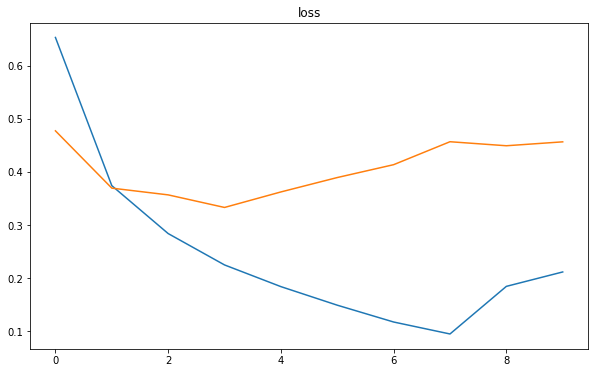

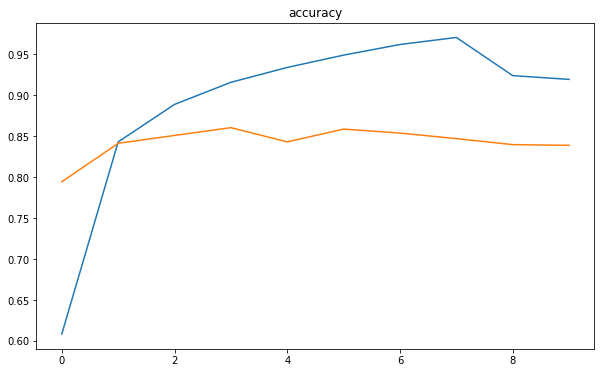

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['loss'])
  plt.plot(history.epoch, history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['accuracy'])
  plt.plot(history.epoch, history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

In [12]:
# LSTM - complete with model definition, summary, fit and plots.

#lstm model definition
lstm = keras.models.Sequential()
lstm.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
lstm.add(keras.layers.LSTM(units=14, activation='tanh'))
lstm.add(keras.layers.Dense(units=1, activation='sigmoid'))

#compile lstm model
lstm.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
#print summary
lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 10)          100000    
                                                                 
 lstm_4 (LSTM)               (None, 14)                1400      
                                                                 
 dense_4 (Dense)             (None, 1)                 15        
                                                                 
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________


In [13]:
#train lstm model
history = lstm.fit(X_train_trim, y_train, epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 12s 25ms/step - loss: 0.5372 - accuracy: 0.7368 - val_loss: 0.3598 - val_accuracy: 0.8531
Epoch 2/10
196/196 [==============================] - 4s 22ms/step - loss: 0.2862 - accuracy: 0.8908 - val_loss: 0.3057 - val_accuracy: 0.8706
Epoch 3/10
196/196 [==============================] - 4s 22ms/step - loss: 0.2070 - accuracy: 0.9263 - val_loss: 0.3006 - val_accuracy: 0.8804
Epoch 4/10
196/196 [==============================] - 4s 22ms/step - loss: 0.1663 - accuracy: 0.9436 - val_loss: 0.3135 - val_accuracy: 0.8731
Epoch 5/10
196/196 [==============================] - 4s 22ms/step - loss: 0.1381 - accuracy: 0.9559 - val_loss: 0.3589 - val_accuracy: 0.8728
Epoch 6/10
196/196 [==============================] - 4s 22ms/step - loss: 0.1140 - accuracy: 0.9644 - val_loss: 0.3557 - val_accuracy: 0.8674
Epoch 7/10
196/196 [==============================] - 4s 22ms/step - loss: 0.1030 - accuracy: 0.9684 - val_loss: 0.4216 - val_accuracy: 0.864

391/391 - 4s - loss: 0.4565 - accuracy: 0.8648 - 4s/epoch - 9ms/step
accuracy: 86.48%


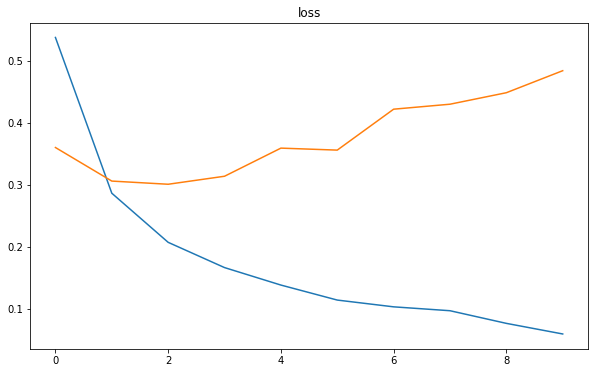

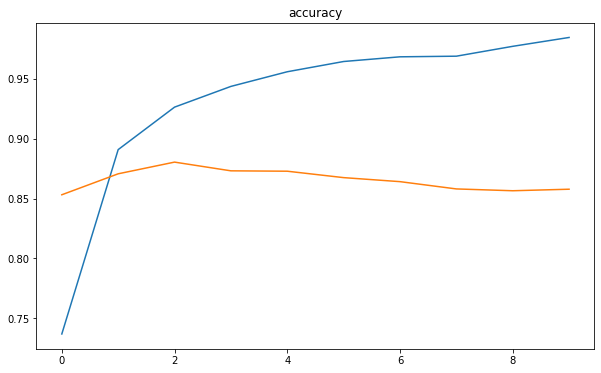

In [16]:
#plot loss and accuracy
plot_loss(history)
plot_accuracy(history)

#evaluate the lstm model
scores = lstm.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (lstm.metrics_names[1], scores[1]*100))

In [19]:
# GRU - complete with model definition, summary, fit and plots.

#gru model definition
gru = keras.models.Sequential()
gru.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
gru.add(keras.layers.GRU(units=16, activation='tanh'))
gru.add(keras.layers.Dense(units=1, activation='sigmoid'))

#compile gru model
gru.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
#print summary
gru.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 10)          100000    
                                                                 
 gru_2 (GRU)                 (None, 16)                1344      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________


In [20]:
#fit gru model
history = gru.fit(X_train_trim, y_train, epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 7s 26ms/step - loss: 0.5530 - accuracy: 0.7000 - val_loss: 0.3688 - val_accuracy: 0.8417
Epoch 2/10
196/196 [==============================] - 4s 22ms/step - loss: 0.2903 - accuracy: 0.8852 - val_loss: 0.3312 - val_accuracy: 0.8628
Epoch 3/10
196/196 [==============================] - 4s 22ms/step - loss: 0.2330 - accuracy: 0.9138 - val_loss: 0.3217 - val_accuracy: 0.8673
Epoch 4/10
196/196 [==============================] - 5s 25ms/step - loss: 0.1921 - accuracy: 0.9326 - val_loss: 0.3431 - val_accuracy: 0.8669
Epoch 5/10
196/196 [==============================] - 4s 22ms/step - loss: 0.1616 - accuracy: 0.9446 - val_loss: 0.3709 - val_accuracy: 0.8641
Epoch 6/10
196/196 [==============================] - 4s 22ms/step - loss: 0.1395 - accuracy: 0.9546 - val_loss: 0.3927 - val_accuracy: 0.8622
Epoch 7/10
196/196 [==============================] - 4s 22ms/step - loss: 0.1272 - accuracy: 0.9587 - val_loss: 0.3949 - val_accuracy: 0.8588

391/391 - 3s - loss: 0.4423 - accuracy: 0.8558 - 3s/epoch - 8ms/step
accuracy: 85.58%


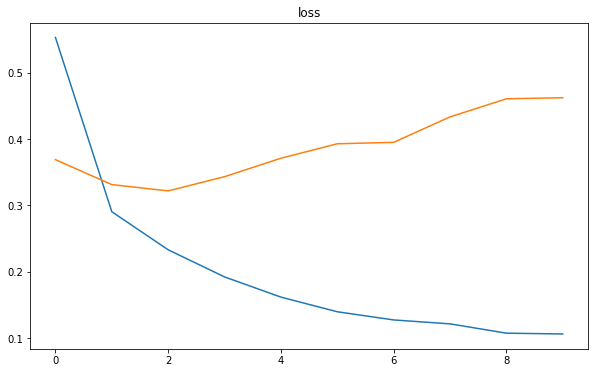

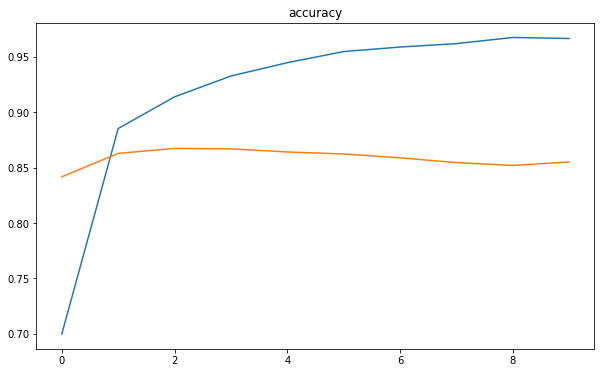

In [22]:
#plot loss and accuracy
plot_loss(history)
plot_accuracy(history)

#evaluate the gru model
scores = gru.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (gru.metrics_names[1], scores[1]*100))

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use?

**Insert cells (code and text) with results and discussion immediately after this cell** 



**Performance**

|||loss|accuracy|
|-|-|-|-|
|SimpleRNN| | 0.4373 | 84.34% |
|LSTM| | 0.4564 | 86.48% |
|GRU| | 0.4423 | 85.58% |

LSTM and GRU have achieved a better accuracy but a slightly higher loss than the SImpleRNN model, probably beacuse the these two architecture are designed for this task, to get better result, since they manage better the vanishing gradient problem. Furthermore, the accuracy obtained with LSTM is greater than GRU, since the GRU architecture is a simpler model compared to LSTM and could suffer about the vanishing gradient problem.

**Number of parameters**

Dealing with the number of units in the last two models, the number of parameters obtained are the following:
* SimpleRNN: 1376
* LSTM: 1400
* GRU: 1344

which are almost the same, as well as the network's total number of parameters. 

**Training time**

The training time of the SimpleRNN model is really greater than the other two models, even though they all have the same number of parameters. Moreover, since the GRU is a simpler architecture, it as a smaller training time, compared to the one of LSTM.

**Number of units**

In order to perform a fair comparison among the models, the LSTM and GRU architecture required a lower number of units to match the same number of parameters of the SimpleRNN model. Moreover, with an equal number of units, GRU model has less parameters to be learnt, compared to the LSTM. Below, the number of units chosen for every model.
* SimpleRNN: 32
* LSTM: 14
* GRU: 16

### Bidirectional LSTM
In conclusion, let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [23]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 10)          100000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               11008     
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 11s 44ms/step - loss: 0.5746 - accuracy: 0.6989 - val_loss: 0.3955 - val_accuracy: 0.8344
Epoch 2/5
196/196 [==============================] - 8s 40ms/step - loss: 0.3192 - accuracy: 0.8712 - v

391/391 - 5s - loss: 0.3501 - accuracy: 0.8681 - 5s/epoch - 14ms/step
accuracy: 86.81%


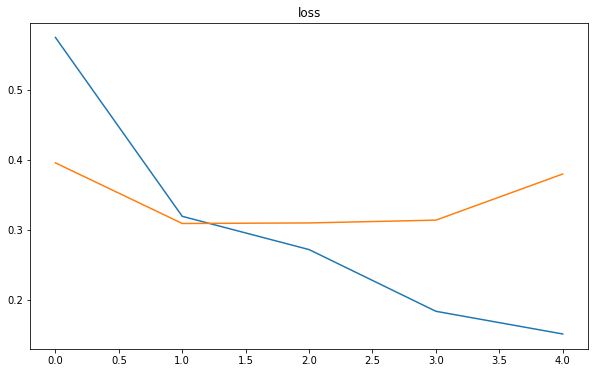

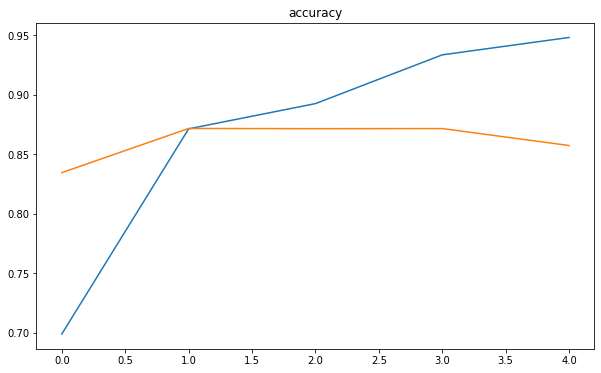

In [24]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

## Exercise 4.3: Transformer

Let's now use a [Transformer](https://arxiv.org/abs/1706.03762) to perform the same task considered in the previous exercise. To define the Transformer we will define a class that inherits from [tensorflow.keras.layers.Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer). This class represents a layer, that is a callable object that takes as input one or more tensors and that outputs one or more tensors. It involves computation, defined in the `call()` method, and a state (weight variables), both defined in the constructor. In the following cell, we will override these two methods in order to define the TransformerLayer. 

The structure of the transformer is defined as follows:
*   A multi-head attention layer, defined using the [tensorflow.keras.layers.MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
*   Dropout operation (*dropout_att*)
*   Layer Normalization (*layernorm_att*)
*   A feedforward Neural Network, defenid by using keras.Sequential, and Dense layer
*   Dropout operation (*dropout_fnn*)
*   Layer Normalization (*layernorm_fnn*) that has in input the summation of the attention layer output and the feedforward NN output



In [25]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_att = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_fnn = layers.LayerNormalization(epsilon=1e-6)
        self.dropout_att = layers.Dropout(rate)
        self.dropout_fnn = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout_att(attn_output, training=training)
        out1 = self.layernorm_att(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout_fnn(ffn_output, training=training)
        return self.layernorm_fnn(out1 + ffn_output)

Due to memory constraints of Transformers the maxlen is reduced to 200.

In [26]:
maxlen = 200
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

To manage the sequential structure of the input, we need to create an embedding of the word + a positional embedding. To perform this operation, similarly to what we did for defining the Transformer layer, we define a new class that inherits from *layer.Layers*. In the unbatched (i.e. single-input) version, this class has in input the index of a word and computes 2 embeddings: the embedding of the word, and the positional embedding. Finally, the method returns the summation of these two embeddings.

In [27]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Now we can define the Transformer model. The model is defined as follows:

*   the Input layer
*   the TokenAndPositionEmbedding layer
*   the Transformer layer
*   2 Dense layers, the second one is the output layer.


**[TO COMPLETE]** Experiment with the `embed_dim, num_heads, ff_dim` and discuss the influence of these parameters in the obtained results, considering the accuracy of the output at the time required to perform the training phase. Report the discussion in the cell at the end of the notebook.

In [84]:
embed_dim = 4  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 2  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [85]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_trim, y_train, batch_size=128, epochs=5, validation_data=(X_valid_trim, y_valid)
)

Epoch 1/5
196/196 [==============================] - 5s 20ms/step - loss: 0.6398 - accuracy: 0.6203 - val_loss: 0.4639 - val_accuracy: 0.7898
Epoch 2/5
196/196 [==============================] - 4s 19ms/step - loss: 0.3190 - accuracy: 0.8746 - val_loss: 0.3164 - val_accuracy: 0.8644
Epoch 3/5
196/196 [==============================] - 4s 19ms/step - loss: 0.2237 - accuracy: 0.9187 - val_loss: 0.3130 - val_accuracy: 0.8728
Epoch 4/5
196/196 [==============================] - 4s 19ms/step - loss: 0.1871 - accuracy: 0.9336 - val_loss: 0.3590 - val_accuracy: 0.8572
Epoch 5/5
196/196 [==============================] - 4s 19ms/step - loss: 0.1580 - accuracy: 0.9463 - val_loss: 0.3684 - val_accuracy: 0.8641


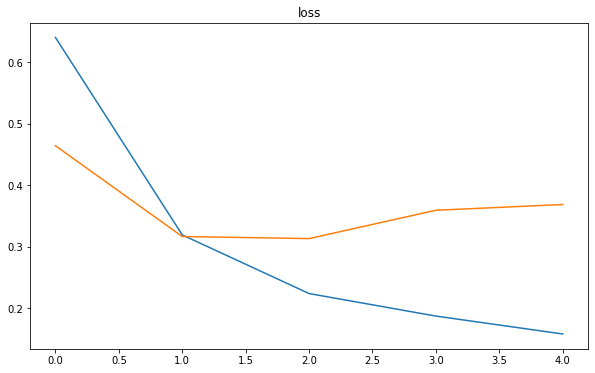

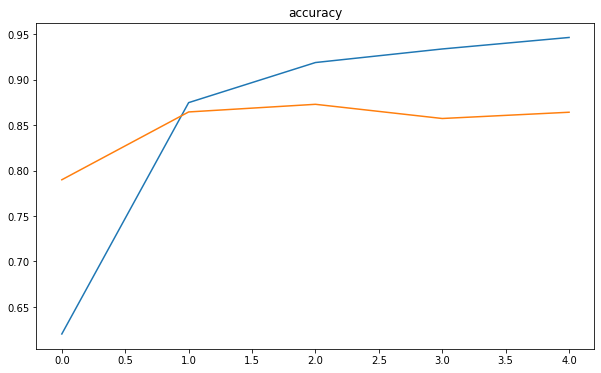

In [87]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

In [86]:
scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

391/391 - 1s - loss: 0.3572 - accuracy: 0.8655 - 1s/epoch - 4ms/step
accuracy: 86.55%


**Insert the discussion here**:

The tested models are the following:

| MODEL | |embed_dim|num_heads|ff_dim| |Loss|Accuracy|
|-|-|-|-|-|-|-|-|
|Model 1| |8|6|4| |0.3949|85.30%|
|Model 2| |16|6|4| |0.4090|85.84%|
|Model 3| |8|2|4| |0.4058|85.54%|
|Model 4| |8|6|2| |0.4016|85.73%|
|Model 5| |4|6|2| |0.3877|86.06%|
|Model 6| |4|4|2| |0.3572|86.55%|

The loss and accuracy columns show that with a smaller number of the parameter *embed_dim*, the model generates better result, in particular keeping it to the range 4-8. Increasing the parameter did not imroved the accuracy while it increased the training time.

Using a greater number of *heads* leads to better results in term of both accuracy and loss, combined with a small embedding size, as it could be the value 4.

Furthermove, even the value of *ff_dim* brings grater accuracy if it is small and once more combined with a lower embedding size as shown in Model 6. The training time increases with bigger values of this parameter.

The best model among the six trained and shown in the table above seems to be the sixth with the following parameters: 
* embed_dim: 4
* num_heads: 4
* ff_dim: 2

which has a loss equal to 0.3572 and an accuracy of 86.55%, the best compared to all the other tested models.